In [125]:
import os, ast, random, time
import numpy as np
import pandas as pd
import wfdb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from ptbxl_utils import setup_dataset, load_ecg
import random


In [126]:
# Set random seed for reproducibility across Python, NumPy and PyTorch
# Keeps model results consistent and reproducible
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f" Random seed set to {seed}\n")

set_seed(42)
SEED = 42  # Keep SEED defined for consistency (used later)

 Random seed set to 42



In [ ]:
data_path = "ptb-xl-dataset-1.0.3"
csv_path = os.path.join(data_path, "ptbxl_database.csv")
df = pd.read_csv(csv_path)

In [ ]:
# dataset config
use_500Hz = False          # True: 500Hz | False: 100Hz
use_filtered = True        # True: AFIB vs NORM, False: AFIB vs ALL

data_path = "ptb-xl-dataset-1.0.3"
csv_path = os.path.join(data_path, "ptbxl_database.csv")
df = pd.read_csv(csv_path)

train_data, val_data, test_data, freq = setup_dataset(
    df,
    train_folds=[1],
    val_folds=[9],
    test_folds=[10],
    use_500Hz=use_500Hz,
    use_filtered=use_filtered
)


#  ECG Load Test
sample_path = train_data.iloc[0]["filename"]
signal, info = load_ecg(sample_path, base_dir=data_path, return_meta=True)

# Verify ECG Record Loading
print("Signal shape:", signal.shape)
print("Metadata:", info)


Selected folds:
 Train: Fold [1] (1086 samples)
 Validation: Fold [9] (1102 samples)
 Test: Fold [10] (1112 samples)
 Total: 3300 samples

Selected ECG sampling rate: 100Hz
Selected dataset mode: Filtered (AFIB vs NORM)
Train      | AFIB: 151    | NORM: 935    | Total: 1086   | AFIB%: 13.90%
Validation | AFIB: 151    | NORM: 951    | Total: 1102   | AFIB%: 13.70%
Test       | AFIB: 152    | NORM: 960    | Total: 1112   | AFIB%: 13.67%

Totals:
 AFIB: 454    | NORM: 2846   | Total: 3300   | AFIB%: 13.76%

Signal shape: (1000, 12)
Metadata: {'fs': 100, 'leads': ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']}


In [128]:
# 7. PyTorch Dataset class
class PTBXL_Dataset(Dataset):
    """Custom dataset: loads ECG signals, normalizes per-lead, returns (tensor, label)."""
    def __init__(self, df_split, base_dir, mean=None, std=None):
        # Store ECG file paths and labels from the DataFrame
        self.paths = df_split["filename"].values
        self.labels = df_split["label"].astype(np.float32).values
        self.base_dir = base_dir

        # Compute normalization stats (mean, std) if not provided
        if mean is None or std is None:
            samp = df_split.sample(min(100, len(df_split)), random_state=SEED)["filename"]
            cat = np.concatenate([load_ecg(p, base_dir=self.base_dir) for p in samp], axis=0)
            self.mean = cat.mean(axis=0)
            self.std  = cat.std(axis=0) + 1e-7
        else:
            # Reuse mean/std from training split for val/test
            self.mean, self.std = mean, std

    # Return number of samples in the dataset
    def __len__(self): return len(self.paths)

    def __getitem__(self, idx):      # idx = index of one ECG record
        # Load ECG signal as NumPy array
        arr = load_ecg(self.paths[idx], base_dir=self.base_dir)
        # Normalize each lead using precomputed mean/std
        arr = (arr - self.mean) / self.std
        # Convert to PyTorch tensor and reorder shape → (channels=12, length)
        arr = torch.from_numpy(arr.T).float()  # (12, L)
        # Get label (0 or 1) as PyTorch tensor
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return arr, label           # Return signal and label pair

In [129]:
# Check if GPU (CUDA) is available for faster training
use_cuda = torch.cuda.is_available()

# Create PyTorch Dataset objects for each data split
# Training computes mean/std; validation and test reuse them for consistency
train_set = PTBXL_Dataset(train_data, base_dir=data_path)
val_set   = PTBXL_Dataset(val_data, base_dir=data_path, mean=train_set.mean, std=train_set.std)
test_set  = PTBXL_Dataset(test_data, base_dir=data_path, mean=train_set.mean, std=train_set.std)

# Wrap datasets into DataLoaders for batching and efficient loading
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=0, pin_memory=use_cuda)
val_loader   = DataLoader(val_set,   batch_size=16, shuffle=False, num_workers=0, pin_memory=use_cuda)
test_loader  = DataLoader(test_set,  batch_size=16, shuffle=False, num_workers=0, pin_memory=use_cuda)

# Prints whether DataLoaders are configured for GPU or CPU use.
print(f"DataLoaders ready (GPU = {use_cuda})\n")

# Fetch one batch and show signal and label shapes
batch = next(iter(train_loader))
print(batch[0].shape, batch[1].shape)



DataLoaders ready (GPU = False)

torch.Size([16, 12, 1000]) torch.Size([16])


Define U-Net mode to detect AF 

In [130]:
# --- 1D U-Net model definition for ECG (PTB-XL) ---

class ConvBNAct1d(nn.Module):
    def __init__(self, in_c, out_c, k=3, s=1, p=None, dropout=0.0):
        super().__init__()
        if p is None:
            p = k // 2
        self.conv = nn.Conv1d(in_c, out_c, k, s, p, bias=False)
        self.bn = nn.BatchNorm1d(out_c)
        self.act = nn.SiLU(inplace=True)
        self.do = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

    def forward(self, x):
        return self.do(self.act(self.bn(self.conv(x))))

class DoubleConv1d(nn.Module):
    def __init__(self, in_c, out_c, dropout=0.0):
        super().__init__()
        self.block = nn.Sequential(
            ConvBNAct1d(in_c, out_c, dropout=dropout),
            ConvBNAct1d(out_c, out_c, dropout=dropout)
        )
    def forward(self, x): return self.block(x)

class Down1d(nn.Module):
    def __init__(self, in_c, out_c, dropout=0.0):
        super().__init__()
        self.pool = nn.MaxPool1d(2)
        self.conv = DoubleConv1d(in_c, out_c, dropout=dropout)
    def forward(self, x): return self.conv(self.pool(x))

class Up1d(nn.Module):
    def __init__(self, in_c, out_c, bilinear=True, dropout=0.0):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="linear", align_corners=True)
            self.conv = DoubleConv1d(in_c, out_c, dropout=dropout)
        else:
            self.up = nn.ConvTranspose1d(in_c//2, in_c//2, 2, stride=2)
            self.conv = DoubleConv1d(in_c, out_c, dropout=dropout)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff = x2.size(-1) - x1.size(-1)
        if diff > 0:
            x1 = F.pad(x1, (diff//2, diff - diff//2))
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class GeM1d(nn.Module):
    def __init__(self, p=3.0, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps
    def forward(self, x):
        x = x.clamp(min=self.eps).pow(self.p)
        x = F.adaptive_avg_pool1d(x, 1).pow(1.0 / self.p)
        return x

class UNet1D(nn.Module):
    def __init__(self, in_channels=12, num_classes=1, base_c=64, dropout=0.0, segmentation=False):
        super().__init__()
        self.segmentation = segmentation
        c1, c2, c3, c4, c5 = base_c, base_c*2, base_c*4, base_c*8, base_c*16

        self.inc = DoubleConv1d(in_channels, c1, dropout)
        self.down1 = Down1d(c1, c2, dropout)
        self.down2 = Down1d(c2, c3, dropout)
        self.down3 = Down1d(c3, c4, dropout)
        self.down4 = Down1d(c4, c5, dropout)

        self.up1 = Up1d(c5 + c4, c4, dropout=dropout)
        self.up2 = Up1d(c4 + c3, c3, dropout=dropout)
        self.up3 = Up1d(c3 + c2, c2, dropout=dropout)
        self.up4 = Up1d(c2 + c1, c1, dropout=dropout)

        if segmentation:
            self.outc = nn.Conv1d(c1, num_classes, kernel_size=1)
        else:
            self.head = nn.Sequential(
                nn.Conv1d(c1, c1, 1, bias=False),
                nn.BatchNorm1d(c1),
                nn.SiLU(inplace=True),
                GeM1d()
            )
            self.fc = nn.Linear(c1, num_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        if self.segmentation:
            return self.outc(x)
        else:
            x = self.head(x).squeeze(-1)
            return self.fc(x)


In [131]:
# --- 1D U-Net Training (binary AFIB vs NORM, PTB-XL) ---

# Make sure UNet1D is defined or imported before this cell
# from train_ptbxl_unet import UNet1D
from torch.amp import autocast, GradScaler   # new AMP API (PyTorch ≥ 2.1)
# 1. Setup

start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UNet1D(
    in_channels=12,
    num_classes=1,
    base_c=64,
    dropout=0.1,
    segmentation=False
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
scaler = GradScaler(device.type, enabled=(device.type == "cuda"))  # ✅ fixed GradScaler init

epochs = 20
best_f1 = -1.0
ckpt_path = "unet1d_binary.pt"

# 2. Training loop

for epoch in range(1, epochs + 1):
    model.train()
    tr_loss, n_steps = 0.0, 0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True).view(-1, 1)

        optimizer.zero_grad(set_to_none=True)

        # --- Forward + backward with AMP ---
        with autocast(device_type=device.type, enabled=(device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        tr_loss += loss.item()
        n_steps += 1

    tr_loss /= max(n_steps, 1)


    # 3. Validation
    model.eval()
    va_loss, n_steps = 0.0, 0
    all_logits, all_targets = [], []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).view(-1, 1)
            with autocast(device_type=device.type, enabled=(device.type == "cuda")):
                logits = model(x)
                loss = criterion(logits, y)
            va_loss += loss.item()
            n_steps += 1
            all_logits.append(logits.float().cpu())
            all_targets.append(y.float().cpu())

    va_loss /= max(n_steps, 1)


    # 4. Compute F1 metric

    logits_np = torch.cat(all_logits).squeeze(1).numpy()
    targets_np = torch.cat(all_targets).squeeze(1).numpy()
    preds_np = (1 / (1 + np.exp(-logits_np)) >= 0.5).astype(np.float32)
    f1 = f1_score(targets_np, preds_np)

    scheduler.step()

    print({
        "epoch": epoch,
        "train_loss": round(tr_loss, 5),
        "val_loss": round(va_loss, 5),
        "val_f1": round(f1, 5)
    })


    # 5. Save best model
  
    if f1 > best_f1:
        best_f1 = f1
        torch.save({
            "model_state": model.state_dict(),
            "best_val_f1": best_f1,
            "epoch": epoch
        }, ckpt_path)

print(f"Done. Best F1 = {best_f1:.4f}. Checkpoint saved to: {ckpt_path}")


Using device: cpu
{'epoch': 1, 'train_loss': 0.30247, 'val_loss': 0.30697, 'val_f1': 0.60328}
{'epoch': 2, 'train_loss': 0.19075, 'val_loss': 0.14536, 'val_f1': 0.68376}
{'epoch': 3, 'train_loss': 0.16248, 'val_loss': 0.14297, 'val_f1': 0.81004}
{'epoch': 4, 'train_loss': 0.12844, 'val_loss': 0.14889, 'val_f1': 0.72441}
{'epoch': 5, 'train_loss': 0.09895, 'val_loss': 0.11801, 'val_f1': 0.768}
{'epoch': 6, 'train_loss': 0.07546, 'val_loss': 0.14655, 'val_f1': 0.80745}
{'epoch': 7, 'train_loss': 0.08484, 'val_loss': 0.11718, 'val_f1': 0.86084}
{'epoch': 8, 'train_loss': 0.06799, 'val_loss': 0.10635, 'val_f1': 0.81369}
{'epoch': 9, 'train_loss': 0.04789, 'val_loss': 0.09053, 'val_f1': 0.87413}
{'epoch': 10, 'train_loss': 0.04769, 'val_loss': 0.07858, 'val_f1': 0.85926}
{'epoch': 11, 'train_loss': 0.03062, 'val_loss': 0.13357, 'val_f1': 0.85276}
{'epoch': 12, 'train_loss': 0.02184, 'val_loss': 0.20164, 'val_f1': 0.72997}
{'epoch': 13, 'train_loss': 0.02404, 'val_loss': 0.06462, 'val_f1': 0

In [144]:
# --- Evaluate 1D U-Net on the Test Set ---

def evaluate_model(model, loader, criterion, device):
    """Evaluate trained U-Net model on a dataloader."""
    model.eval()
    test_loss, n_steps = 0.0, 0
    all_logits, all_targets = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True).view(-1, 1)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == "cuda")):
                logits = model(x)
                loss = criterion(logits, y)

            test_loss += loss.item()
            n_steps += 1
            all_logits.append(logits.float().cpu())
            all_targets.append(y.float().cpu())

    test_loss /= max(n_steps, 1)

    # Convert tensors to NumPy arrays
    logits_np = torch.cat(all_logits).squeeze(1).numpy()
    targets_np = torch.cat(all_targets).squeeze(1).numpy()
    preds_np = (1 / (1 + np.exp(-logits_np)) >= 0.5).astype(np.int32)

    test_f1 = f1_score(targets_np, preds_np)
    test_acc = accuracy_score(targets_np, preds_np)

    return test_loss, test_f1, test_acc, targets_np, preds_np


# Load best checkpoint & evaluate on test set
start_time = time.time()

# Load best checkpoint
ckpt_path = "unet1d_binary.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
model.load_state_dict(checkpoint["model_state"])
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with best F1 = {checkpoint['best_val_f1']:.4f}")

# Evaluate on test set
test_loss, test_f1, test_acc, y_true, y_pred = evaluate_model(model, test_loader, criterion, device)


# Results Summary

print("\nTest Metrics Summary")
print(f"  Test Loss:     {test_loss:.4f}")
print(f"  Test F1-score: {test_f1:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Sampling frequency: {freq} Hz")
print(f"  Device used: {'GPU' if device.type == 'cuda' else 'CPU'}")

# Switch model to eval mode for stable inference
model.eval()

# Label mapping
print("\nLabel mapping:")
print("0 = Normal Sinus Rhythm (NORM)")
print("1 = Atrial Fibrillation (AFIB)")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "AFIB"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
total_normal = cm[0].sum()
total_afib = cm[1].sum()

print(f"{tn} Normal ECGs correctly classified ({tn/total_normal*100:.1f}%)")
print(f"{fp} Normal ECGs wrongly predicted as AFIB ({fp/total_normal*100:.1f}%) [False Positives]")
print(f"{tp} AFIB ECGs correctly classified ({tp/total_afib*100:.1f}%)")
print(f"{fn} AFIB ECGs wrongly predicted as Normal ({fn/total_afib*100:.1f}%) [False Negatives]")

# Dataset summary
print("\nDataset Sizes:")
print(f"  Training records:   {len(train_data)}")
print(f"  Validation records: {len(val_data)}")
print(f"  Test records:       {len(test_data)}")

# Runtime summary
end_time = time.time()
total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"\nRuntime: {int(hours):02d}h {int(minutes):02d}m {int(seconds):02d}s")




Loaded checkpoint from epoch 15 with best F1 = 0.9420

Test Metrics Summary
  Test Loss:     0.0694
  Test F1-score: 0.9167
  Test Accuracy: 0.9784
  Sampling frequency: 100 Hz
  Device used: CPU

Label mapping:
0 = Normal Sinus Rhythm (NORM)
1 = Atrial Fibrillation (AFIB)

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       960
        AFIB       0.97      0.87      0.92       152

    accuracy                           0.98      1112
   macro avg       0.98      0.93      0.95      1112
weighted avg       0.98      0.98      0.98      1112

Confusion Matrix:
[[956   4]
 [ 20 132]]
956 Normal ECGs correctly classified (99.6%)
4 Normal ECGs wrongly predicted as AFIB (0.4%) [False Positives]
132 AFIB ECGs correctly classified (86.8%)
20 AFIB ECGs wrongly predicted as Normal (13.2%) [False Negatives]

Dataset Sizes:
  Training records:   1086
  Validation records: 1102
  Test records:       1112

Runtime: 00h 00m

Grad-CAM Explainability

In [145]:

class GradCAM1D:
    """
    Computes Grad-CAM for 1D convolutional models (e.g., CNN1D, UNet1D)
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, x, class_idx=None):
        self.model.zero_grad()
        x = x.clone().detach().requires_grad_(True)
        logits = self.model(x)

        if class_idx is None:
            class_idx = 0  # for binary classifier (AFIB score)

        score = logits[:, class_idx].sum()
        score.backward(retain_graph=True)

        # Global average pooling of gradients -> importance weights
        weights = self.gradients.mean(dim=2, keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = F.relu(cam)
        cam = cam / (cam.max(dim=1, keepdim=True)[0] + 1e-8)
        return cam.detach().cpu().numpy(), logits.detach().cpu()

# 2. Multi-lead Grad-CAM Plot (12 leads)

def plot_gradcam_12leads(ecg_tensor, cam, title="Grad-CAM (12-lead ECG)", figsize=(14,10)):
    ecg_np = ecg_tensor[0].cpu().numpy()
    cam_np = cam[0]

    # Match CAM and ECG length
    if len(cam_np) != ecg_np.shape[1]:
        cam_np = np.interp(np.arange(ecg_np.shape[1]),
                           np.linspace(0, ecg_np.shape[1]-1, len(cam_np)),
                           cam_np)

    # Normalize CAM to 0–1
    cam_np = (cam_np - cam_np.min()) / (cam_np.max() + 1e-8)

    leads = [f"Lead {i+1}" for i in range(ecg_np.shape[0])]
    fig, axes = plt.subplots(6, 2, figsize=figsize, sharex=True)
    axes = axes.flatten()

    for i in range(12):
        ecg_lead = ecg_np[i]
        axes[i].plot(ecg_lead, color='b', linewidth=0.8)
        axes[i].fill_between(np.arange(len(ecg_lead)),
                             0,
                             cam_np * ecg_lead.max(),
                             color='r', alpha=0.25)
        axes[i].set_title(leads[i], fontsize=10)
        axes[i].set_ylim(ecg_lead.min()*1.2, ecg_lead.max()*1.2)
        axes[i].grid(alpha=0.3)

    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return cam_np

# 3. Single-lead Grad-CAM Overlay Plot

def plot_gradcam_singlelead(ecg_tensor, cam, lead=0, title="Grad-CAM (Single Lead)", figsize=(12,4), save_path=None):
    ecg_np = ecg_tensor[0, lead].cpu().numpy()
    cam_np = cam[0]

    # Interpolate Grad-CAM if lengths differ
    if len(cam_np) != len(ecg_np):
        cam_np = np.interp(np.arange(len(ecg_np)),
                           np.linspace(0, len(ecg_np)-1, len(cam_np)),
                           cam_np)

    cam_np = (cam_np - cam_np.min()) / (cam_np.max() + 1e-8)

    plt.figure(figsize=figsize)
    plt.plot(ecg_np, color='b', label='ECG')
    plt.plot(cam_np * ecg_np.max(), color='r', label='Grad-CAM', alpha=0.8)
    plt.title(title)
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude / Importance")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        print(f" Saved Grad-CAM figure → {save_path}")

    plt.show()

# 4. Automatic Interpretation Summary

def interpret_gradcam(cam_np, num_segments=10):
    L = len(cam_np)
    seg_len = L // num_segments
    segment_strengths = [
        cam_np[i*seg_len:(i+1)*seg_len].mean()
        for i in range(num_segments)
    ]
    top_segments = np.argsort(segment_strengths)[-3:][::-1] + 1
    print("\nGrad-CAM Interpretation:")
    print(f"- Strongest attention in segments: {list(top_segments)} / {num_segments}")
    print("- Red = regions model focused on most for prediction.")
    print("- Irregular, scattered peaks → AFIB | Rhythmic peaks → Normal Sinus Rhythm.")


# 5. Run Grad-CAM on one ECG record
# Pick the last convolutional block from your UNet decoder
target_layer = model.up4.conv.block[-1]  # adjust if your UNet is named differently
gradcam = GradCAM1D(model, target_layer)




In [146]:

# ECG Sample Selector — for UNet1D Grad-CAM


def select_ecg_sample(test_loader, manual_index=None, show_list=False, num_show=10, device='cpu'):
    dataset = test_loader.dataset
    n_total = len(dataset)

    if show_list:
        print(f"Test dataset has {n_total} samples.")
        print("Showing first few indices and labels:")
        for i in range(min(num_show, n_total)):
            _, y_i = dataset[i]
            label = "AFIB" if int(y_i.item()) == 1 else "Normal"
            print(f"   #{i:3d} → {label}")
        print("------------------------------------------------------")

    if manual_index is None:
        idx = random.randint(0, n_total - 1)
        mode = "Random"
    else:
        idx = int(manual_index)
        mode = "Manual"

    x, y = dataset[idx]
    x = x.unsqueeze(0).to(device)
    y = y.unsqueeze(0)

    label_str = "AFIB" if y.item() == 1 else "Normal Sinus Rhythm"

    print(f"{mode} selection → Test sample #{idx}")
    print(f"   True label: {label_str} (y={int(y.item())})")

    return x, y, idx, label_str

# --- Example use ---
# manual_index = 42  # to pick specific ECG
manual_index = None   # or None for random ECG
x, y, idx, label_str = select_ecg_sample(
    test_loader,
    manual_index=manual_index,
    show_list=True,
    num_show=10,
    device=device
)


Test dataset has 1112 samples.
Showing first few indices and labels:
   #  0 → Normal
   #  1 → Normal
   #  2 → Normal
   #  3 → Normal
   #  4 → Normal
   #  5 → Normal
   #  6 → Normal
   #  7 → Normal
   #  8 → Normal
   #  9 → Normal
------------------------------------------------------
Random selection → Test sample #501
   True label: Normal Sinus Rhythm (y=0)



 Model Prediction (UNet1D): Normal Sinus Rhythm
   Confidence: 0.001


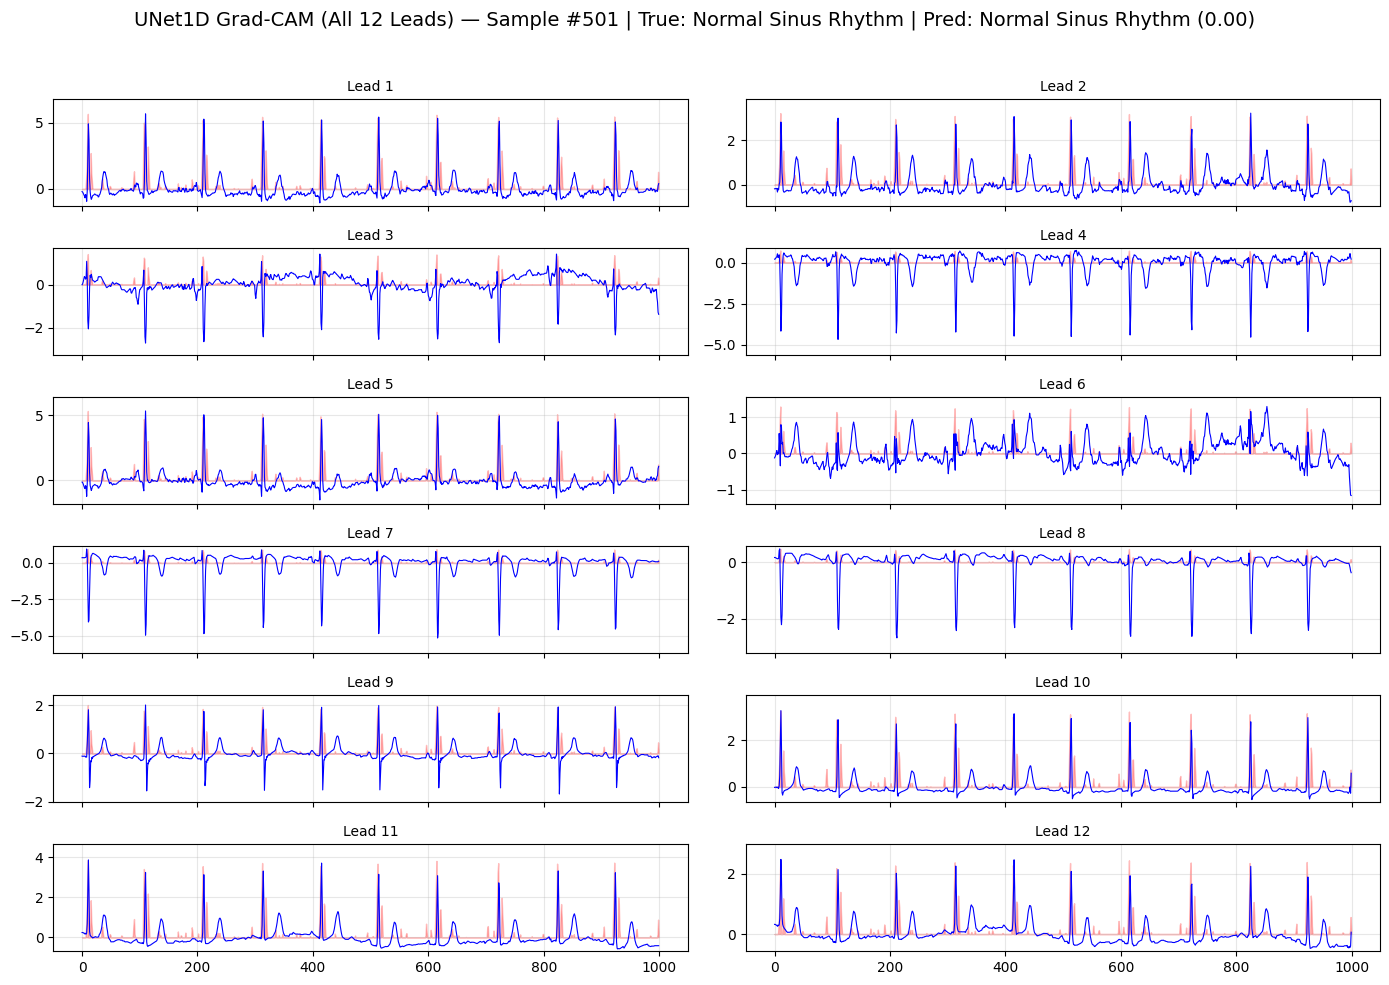

 Saved Grad-CAM figure → gradcam_results/sample_501_unet_lead2.png


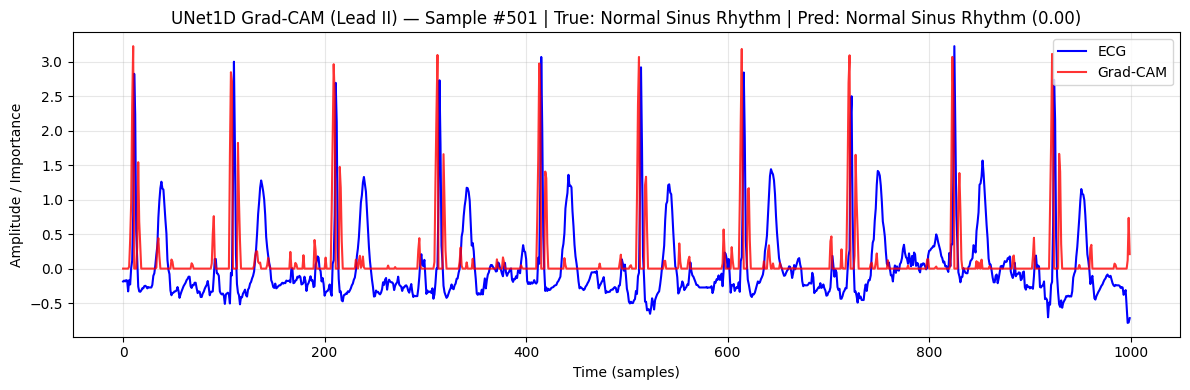


Grad-CAM Interpretation:
- Strongest attention in segments: [np.int64(10), np.int64(3), np.int64(2)] / 10
- Red = regions model focused on most for prediction.
- Irregular, scattered peaks → AFIB | Rhythmic peaks → Normal Sinus Rhythm.


In [147]:

# Grad-CAM Visualization — UNet1D

# Ensure GradCAM1D, plot_gradcam_12leads, plot_gradcam_singlelead, interpret_gradcam
# are already defined in your notebook.

# Target Layer
target_layer = model.up4.conv.block[-1]   # last decoder block in UNet1D
gradcam = GradCAM1D(model, target_layer)

# Compute Grad-CAM
cam, logits = gradcam.generate(x)
prob = torch.sigmoid(logits).item()
pred_label = "AFIB" if prob >= 0.5 else "Normal Sinus Rhythm"

# Output Summary
print(f"\n Model Prediction (UNet1D): {pred_label}")
print(f"   Confidence: {prob:.3f}")

# Plot Grad-CAM
title_base = f"Sample #{idx} | True: {label_str} | Pred: {pred_label} ({prob:.2f})"

cam_np = plot_gradcam_12leads(
    x, cam, title=f"UNet1D Grad-CAM (All 12 Leads) — {title_base}"
)

plot_gradcam_singlelead(
    x, cam, lead=1,
    title=f"UNet1D Grad-CAM (Lead II) — {title_base}",
    save_path=f"gradcam_results/sample_{idx}_unet_lead2.png"
)

# Interpretation
interpret_gradcam(cam_np)
